# <center>Unsupervised Adversarial Image Inpainting</center>

##### Standard settings

| Parameter | Value |
| --- | --- |
| nz | 16 |
| $\lambda_{L1}$ | 1 |
| $\lambda_{z}$ | 1|
| $num\_sample$ | 8 |
| $gan\_mode$ | hinge |

modules:
  gen:
    _name: pix2pix (this is resnet generator)
    input_nc: 3
    ngf: 16
    nz: *nz
    init_name: orthogonal
    init_gain: 0.02

  dis:
    _name: biggan_dis
    input_nc: 3
    ndf: 16
    init_name: orthogonal
    init_gain: 1.41

  enc:
    _name: biggan_dis
    input_nc: 3
    ndf: 16
    output_dim: *nz
    init_name: orthogonal
    init_gain: 1.41


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import functools
from tqdm.notebook import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter as P
from torch.nn.utils import spectral_norm
import torch.utils.data as data
from torchvision import transforms, datasets

from src.models.discriminator import *
from src.models.generator import *
from src.models.pix2pix_factory import *
from src.corruptions_static import *
from src.dataset_experiment import *

import warnings

warnings.filterwarnings("ignore")

In [8]:
device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
BATCH_SIZE = 32
IM_SIZE = 128
ngf = 16
ndf = 16
nz = 16 # Latent vector dimensions
niter = 50
DATASET = "CIFAR"

Files already downloaded and verified
(3, 128, 128) (3, 128, 128)


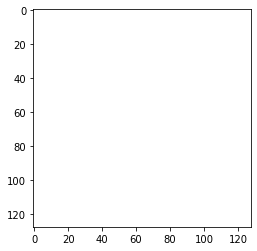

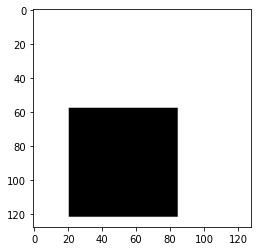

In [9]:
transform = transforms.Compose([transforms.Resize(IM_SIZE),
                                transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if DATASET == "CIFAR":
    
    # Load CIFAR-10 dataset
    train_set = datasets.CIFAR10(root='./data', train=True,
                                    download=True,
                                   transform = transform)

    train_loader = torch.utils.data.DataLoader(train_set, 
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=0,
                                                drop_last=True)

elif DATASET == "CELEBA":
    
    # Load CelebA dataset
    train_set = datasets.CelebA(root='./data', 
                                       split='train',
                                       download=False,
                                       transform = transform)

    train_loader = torch.utils.data.DataLoader(train_set, 
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=0,
                                                drop_last=True)

# Corruption
corr = KeepPatch(im_size=IM_SIZE)
#corr = RemovePixelDark(im_size=IM_SIZE)

random = torch.ones((1, 3, 128, 128))*1

corrupted_random = corr(random)

random = random[0].cpu().numpy()
corrupted_random = corrupted_random[0][0].cpu().numpy()
print(np.shape(random), np.shape(corrupted_random))
plt.imshow(random.swapaxes(0,2))
plt.show()

plt.imshow(corrupted_random.swapaxes(0,2))
plt.show()

In [10]:
# Neural nets
gen = ResnetGenerator(input_nc=3, ngf=ngf, nz=nz)
dis = Discriminator(resolution=64, ndf=ndf, nz=nz)
enc = Discriminator(resolution=64, ndf=ndf, nz=nz, output_dim=nz)

# Optimisers
optim_gen = torch.optim.Adam(gen.parameters(), lr=4e-5, betas=(.0,.99))
optim_dis = torch.optim.Adam(dis.parameters(), lr=1e-5, betas=(.0,.99))
#optim_dis = torch.optim.SGD(dis.parameters(), lr=1e-2, momentum=0.9)

kwargs = {"gen": gen,
          "dis": dis,
          "enc": enc,
          "optim_gen": optim_gen,
          "optim_dis": optim_dis,
          "nz": nz,
          "train": train_loader,
          "niter": 100,
          "nepoch": EPOCHS,
          "ngf": ngf,
          "ndf": ndf,
          "corruption": corr}

experiment = UnsupervisedImageInpainting(**kwargs)

Adding attention layer in D at resolution 32
Adding attention layer in D at resolution 32


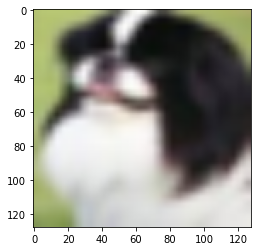

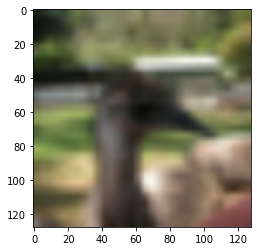

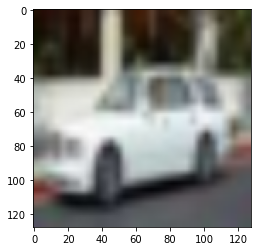

In [11]:
# Loop over data

for i in range(3):

    sample = next(iter(train_loader))
    img = sample[0][0]*0.5 + 0.5

    img = img.cpu().numpy()
    plt.imshow(img.swapaxes(0,2).swapaxes(0,1))
    plt.show()

In [12]:
counter = 0

for epoch in range(1, EPOCHS+1):

    for inputs, targets in tqdm(train_loader):
        
        counter+=1
        
        if counter > 2:
            break

        x = torch.Tensor(inputs.float()).to(device)
        label = torch.Tensor(targets.float()).double().to(device)
        mask = corr.sample_theta(x.shape) # Theta not currently used...
        mask = torch.Tensor(mask).bool()
        y, mask = corr(x, theta=mask)
        
        experiment.optimize(x = None, y=y, label=None, theta=mask, device=device, **kwargs)

LOOK HERE: torch.FloatTensor, torch.BoolTensor, torch.FloatTensor



RuntimeError: expected device cpu but got device cuda:0

In [13]:
device

'cpu'